<a href="https://colab.research.google.com/github/manukala6/processing/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
!pip install pyproj

     |████████████████████████████████| 10.1MB 9.4MB/s 


In [0]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from pyproj import Proj

**Authenticate and Initialize**

In [3]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/tQEqB5EDtZ8IjFLIan8wC7zFWMUpX9IGOieJEC7W6Z3McUCH47fwpqE

Successfully saved authorization token.


In [0]:
ee.Initialize()

**Collect Imagery from Assets**

In [0]:
# links to earth engine image assets
naiman_image_links = [
  'users/manukala6/naimanResiduals/naimanResiduals1985',
  'users/manukala6/naimanResiduals/naimanResiduals1986',
  'users/manukala6/naimanResiduals/naimanResiduals1987',
  'users/manukala6/naimanResiduals/naimanResiduals1988',
  'users/manukala6/naimanResiduals/naimanResiduals1989',
  'users/manukala6/naimanResiduals/naimanResiduals1991',
  'users/manukala6/naimanResiduals/naimanResiduals1992',
  'users/manukala6/naimanResiduals/naimanResiduals1993',
  'users/manukala6/naimanResiduals/naimanResiduals1994',
  'users/manukala6/naimanResiduals/naimanResiduals1995',
  'users/manukala6/naimanResiduals/naimanResiduals1996',
  'users/manukala6/naimanResiduals/naimanResiduals1997',
  'users/manukala6/naimanResiduals/naimanResiduals1998',
  'users/manukala6/naimanResiduals/naimanResiduals1999',
  'users/manukala6/naimanResiduals/naimanResiduals2000',
  'users/manukala6/naimanResiduals/naimanResiduals2001',
  'users/manukala6/naimanResiduals/naimanResiduals2002',
  'users/manukala6/naimanResiduals/naimanResiduals2003',
  'users/manukala6/naimanResiduals/naimanResiduals2004',
  'users/manukala6/naimanResiduals/naimanResiduals2005']

# earth engine geometry of study area
study_area = ee.Geometry.Polygon(
        [[[120.57634266181299, 43.154841164437116],
          [120.57634266181299, 43.11575743324893],
          [120.66560657782861, 43.11575743324893],
          [120.66560657782861, 43.154841164437116]]]);

In [0]:
naiman_images = []
for image_link in naiman_image_links:
  naiman_images.append(ee.Image(image_link))

**Create an array of shape** `(num_years, num_bands, num_pixels)`

In [0]:
# function to generate numpy array images from image collection
def convert_ee2ndarray (ee_image):
  # gather decimal coordinates per pixel
  lat_lon = ee_image.clip(study_area).pixelLonLat().addBands(ee_image)
  lat_lon = lat_lon.reduceRegion(
      reducer=ee.Reducer.toList(),
      geometry=study_area,
      scale=30,
      maxPixels=10000000000
  )
  # convert each band to nd array
  ndvi = np.array((ee.Array(lat_lon.get('ndviCalendar')).getInfo()))
  precip = np.array((ee.Array(lat_lon.get('precipitation')).getInfo()))
  latitude = np.array((ee.Array(lat_lon.get('latitude')).getInfo()))
  longitude = np.array((ee.Array(lat_lon.get('longitude')).getInfo()))
  # stack band arrays
  return np.stack((ndvi, precip, latitude, longitude))

In [0]:
# do the thing
naiman_arr_images = []
for i in range(0,5):
  naiman_arr_images.append(convert_ee2ndarray(naiman_images[i]))

In [0]:
# stack into one array of shape len(naiman_images)
naiman_arr = np.asarray(naiman_arr_images)

In [10]:
# check the shape
naiman_arr.shape

(5, 4, 47995)

In [18]:
point_ndvi_arr = naiman_arr[:,0,0]
year_arr = np.array([])
for i in range(0, point_ndvi_arr.shape[0]):
  year_arr = np.append(year_arr, i+1985)
year_arr.astype(int)

array([1985, 1986, 1987, 1988, 1989])

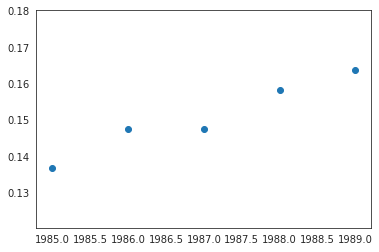

In [32]:
ax = plt.scatter(x=year_arr, y=point_ndvi_arr)